In [1]:
from qiskit import QuantumRegister, QuantumCircuit
import matplotlib

In [11]:
from qiskit_ibm_provider import IBMProvider
# IBMProvider.save_account('a4216d8e3d0791f1496a69dd9edcf472a0e7ed7c8ca57fe15b33a9af5fdd1c970bb4d8feff0e2986d4810a3c34fba9ffeda9c07ecdde6e8339a8ad4beaa27ab2')
provider = IBMProvider()
provider.active_account()
# IBMProvider.delete_account()

{'channel': 'ibm_quantum',
 'token': 'a4216d8e3d0791f1496a69dd9edcf472a0e7ed7c8ca57fe15b33a9af5fdd1c970bb4d8feff0e2986d4810a3c34fba9ffeda9c07ecdde6e8339a8ad4beaa27ab2',
 'url': 'https://auth.quantum-computing.ibm.com/api',
 'verify': True,
 'instance': 'ibm-q/open/main'}

D:\Programs\Anaconda3\envs\qiskitenv\lib\site-packages\qiskit\visualization\circuit\matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


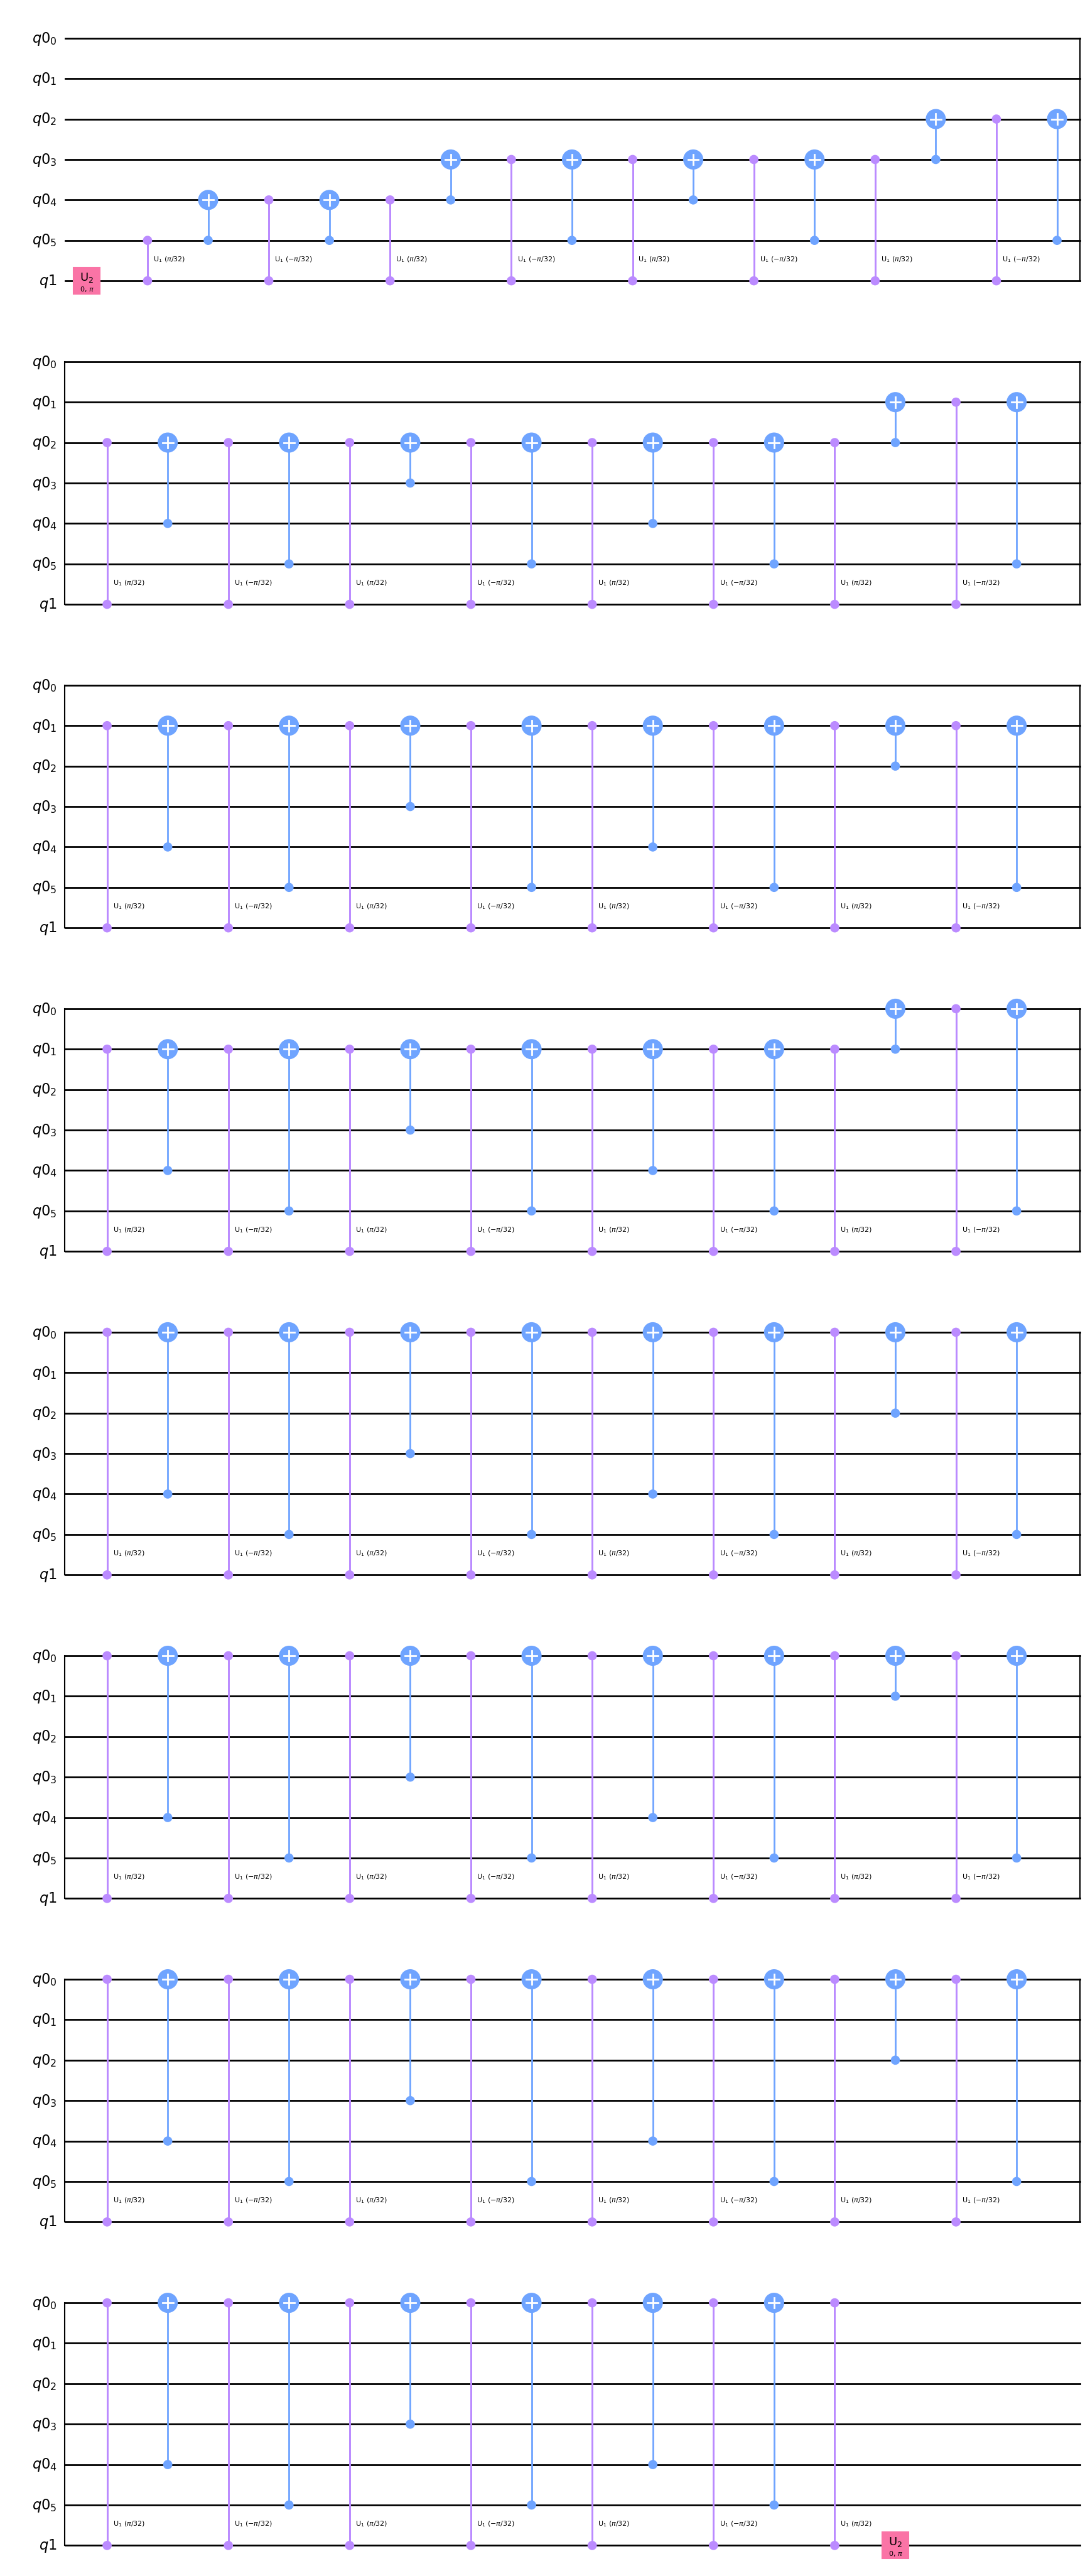

In [2]:
control = QuantumRegister(6)
target = QuantumRegister(1)
qc = QuantumCircuit(control, target)
qc.mcx(control, target[0])
qc.decompose().decompose().draw('mpl')

C:\ProgramData\anaconda3\envs\qiskitenv\lib\site-packages\qiskit\visualization\circuit\matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


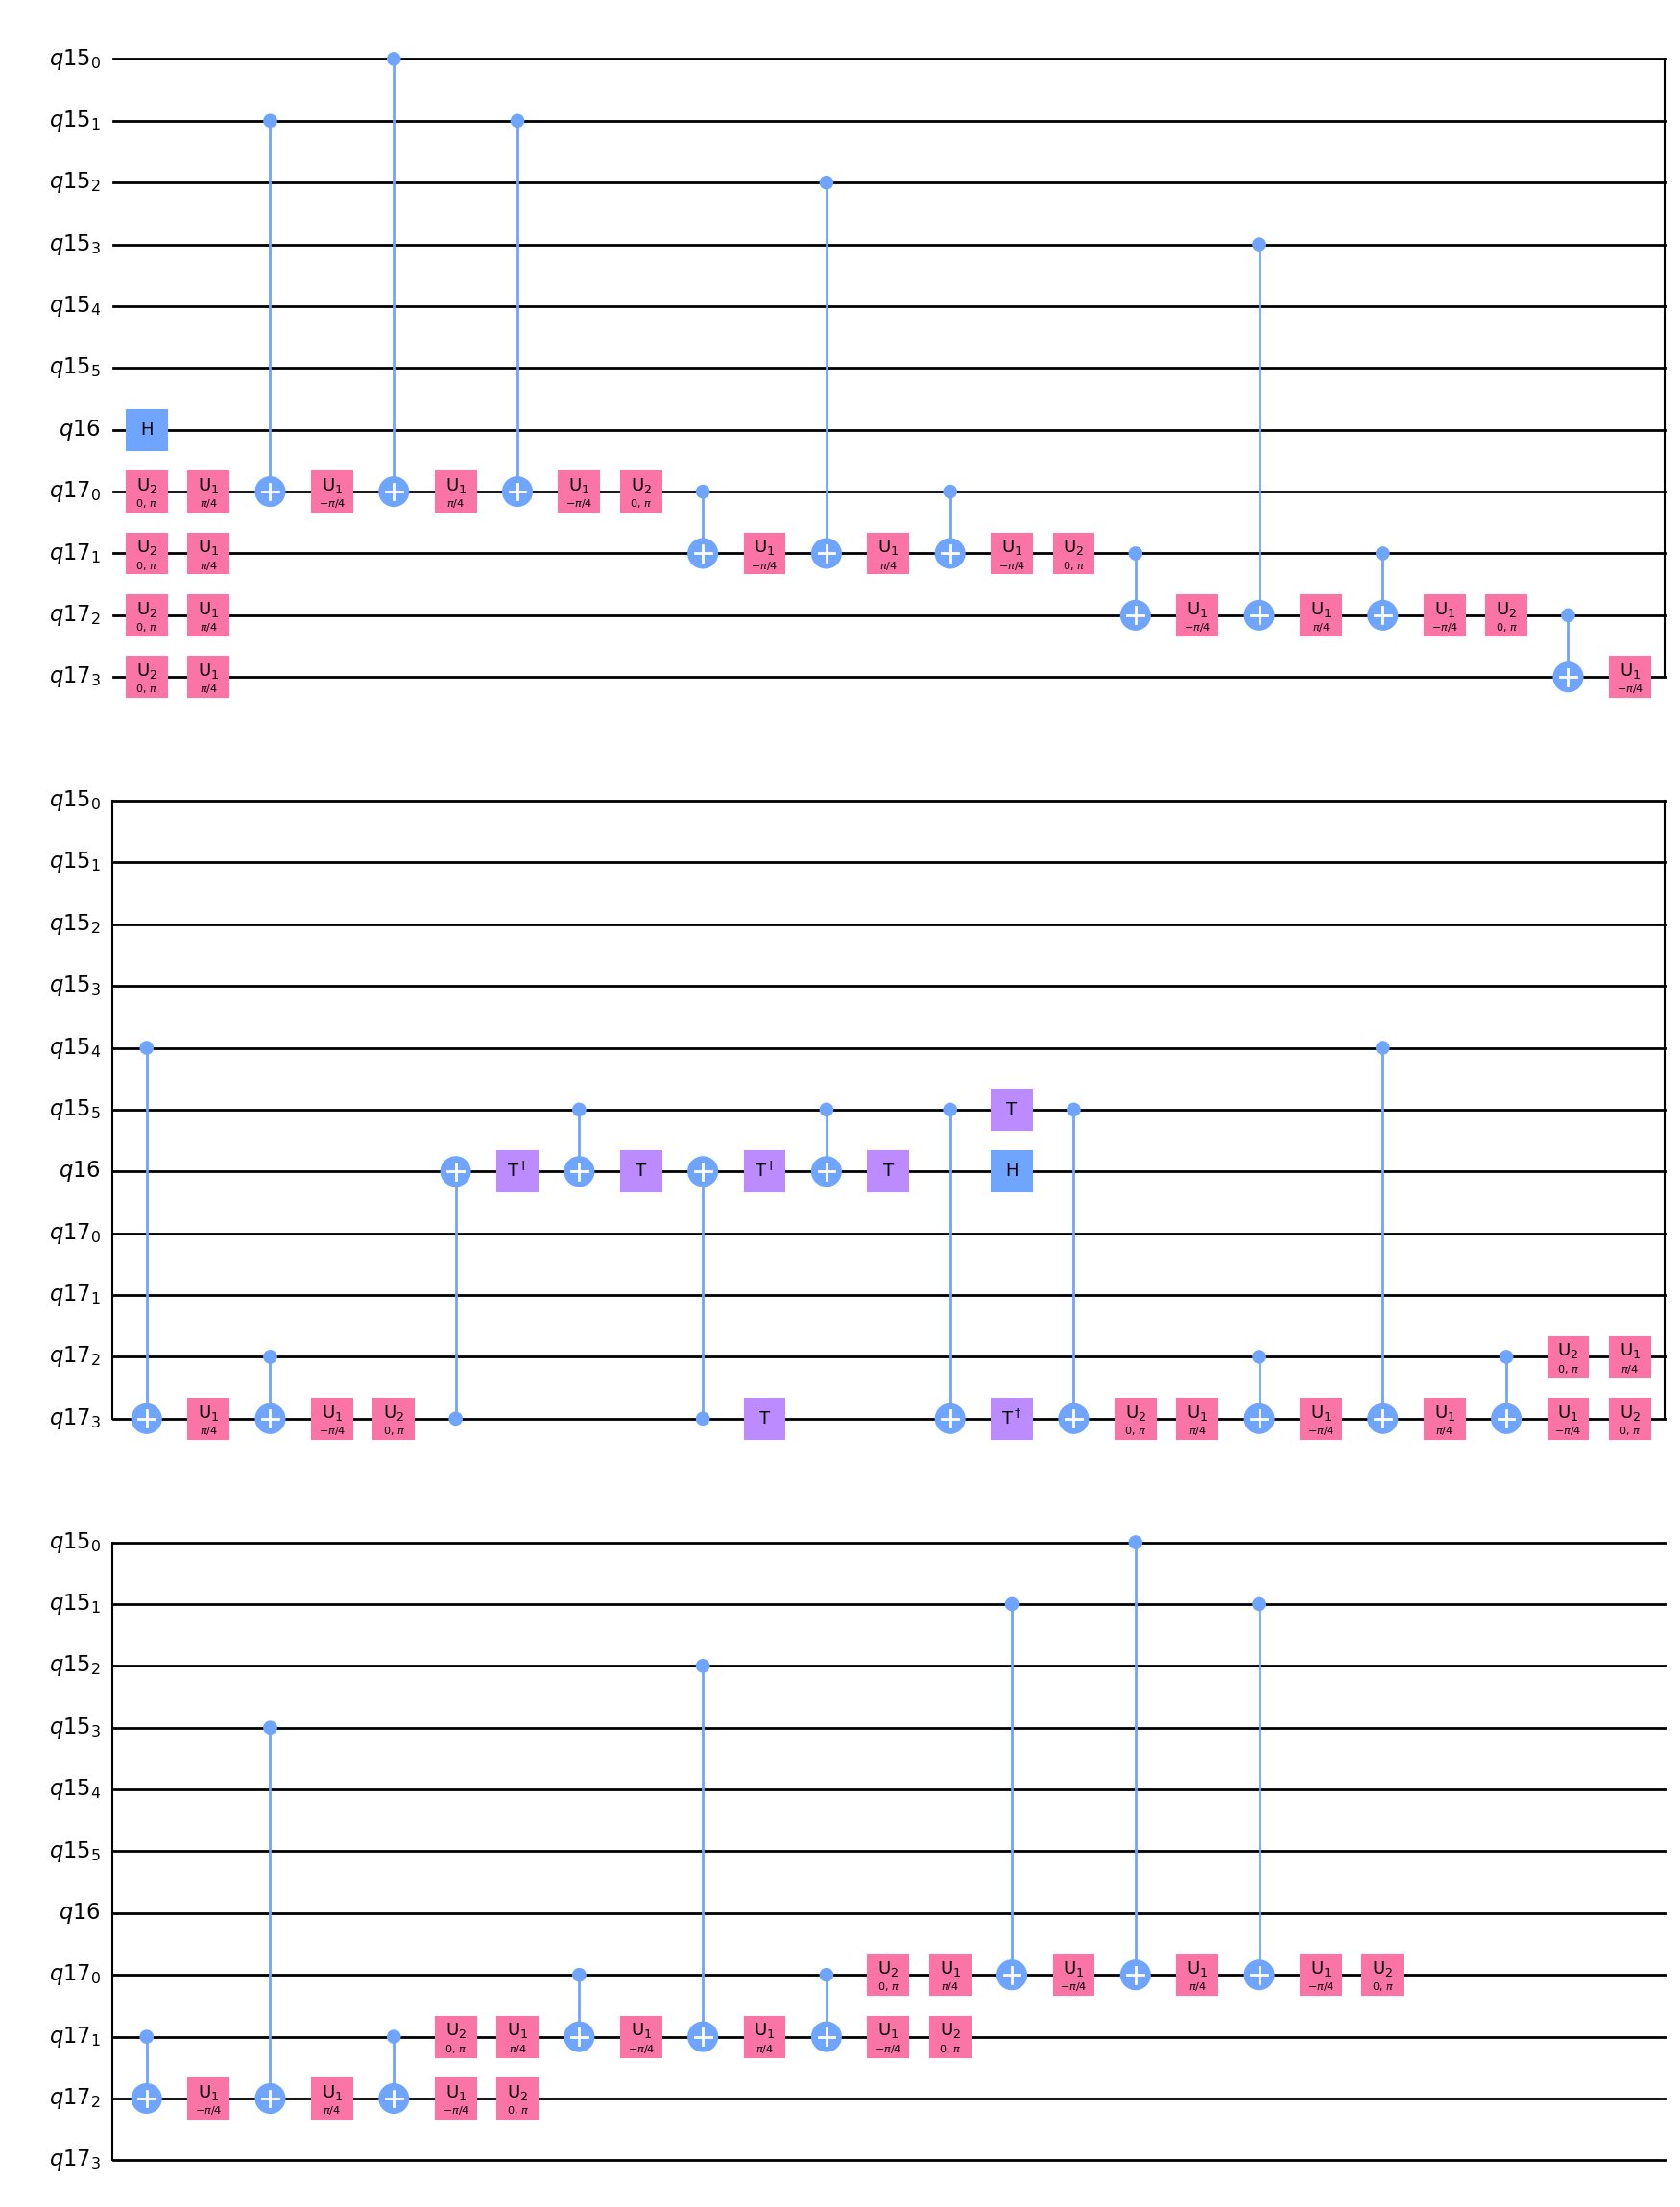

In [8]:
control = QuantumRegister(6)
target = QuantumRegister(1)
anc = QuantumRegister(4)
qc = QuantumCircuit(control, target, anc)
qc.mcx(control, target[0], anc, mode='v-chain')
qc.decompose().decompose().draw('mpl')

In [6]:
from qiskit import QuantumCircuit, Aer, execute
qc = QuantumCircuit(3)
qc.x(0)
qc.measure_all()

backend = Aer.get_backend("qasm_simulator")
job = execute(qc, backend, shots=1)
count = job.result().get_counts()
print(count)
print(list(count)[0])

{'001': 1}
001


In [7]:
import math as m 
print(m.asin(0.00175))

0.0017500008932303977


In [1]:
import numpy as np

# 生成一个5x5的随机数组，每个值大于0
positive_random_array = np.random.uniform(0.1, 10.0, (3, 3))

print(positive_random_array)

[[2.8142878  3.44001605 2.48575698]
 [2.50773914 2.32780009 4.14125567]
 [4.48568069 4.30635414 3.24669325]]


[[ 1.        +0.j          0.        +0.j          0.        +0.j
   0.        +0.j        ]
 [ 0.        +0.j          1.        +0.j          0.        +0.j
   0.        +0.j        ]
 [ 0.        +0.j          0.        +0.j         -0.30901699+0.95105652j
   0.        +0.j        ]
 [ 0.        +0.j          0.        +0.j          0.        +0.j
  -0.80901699+0.58778525j]]


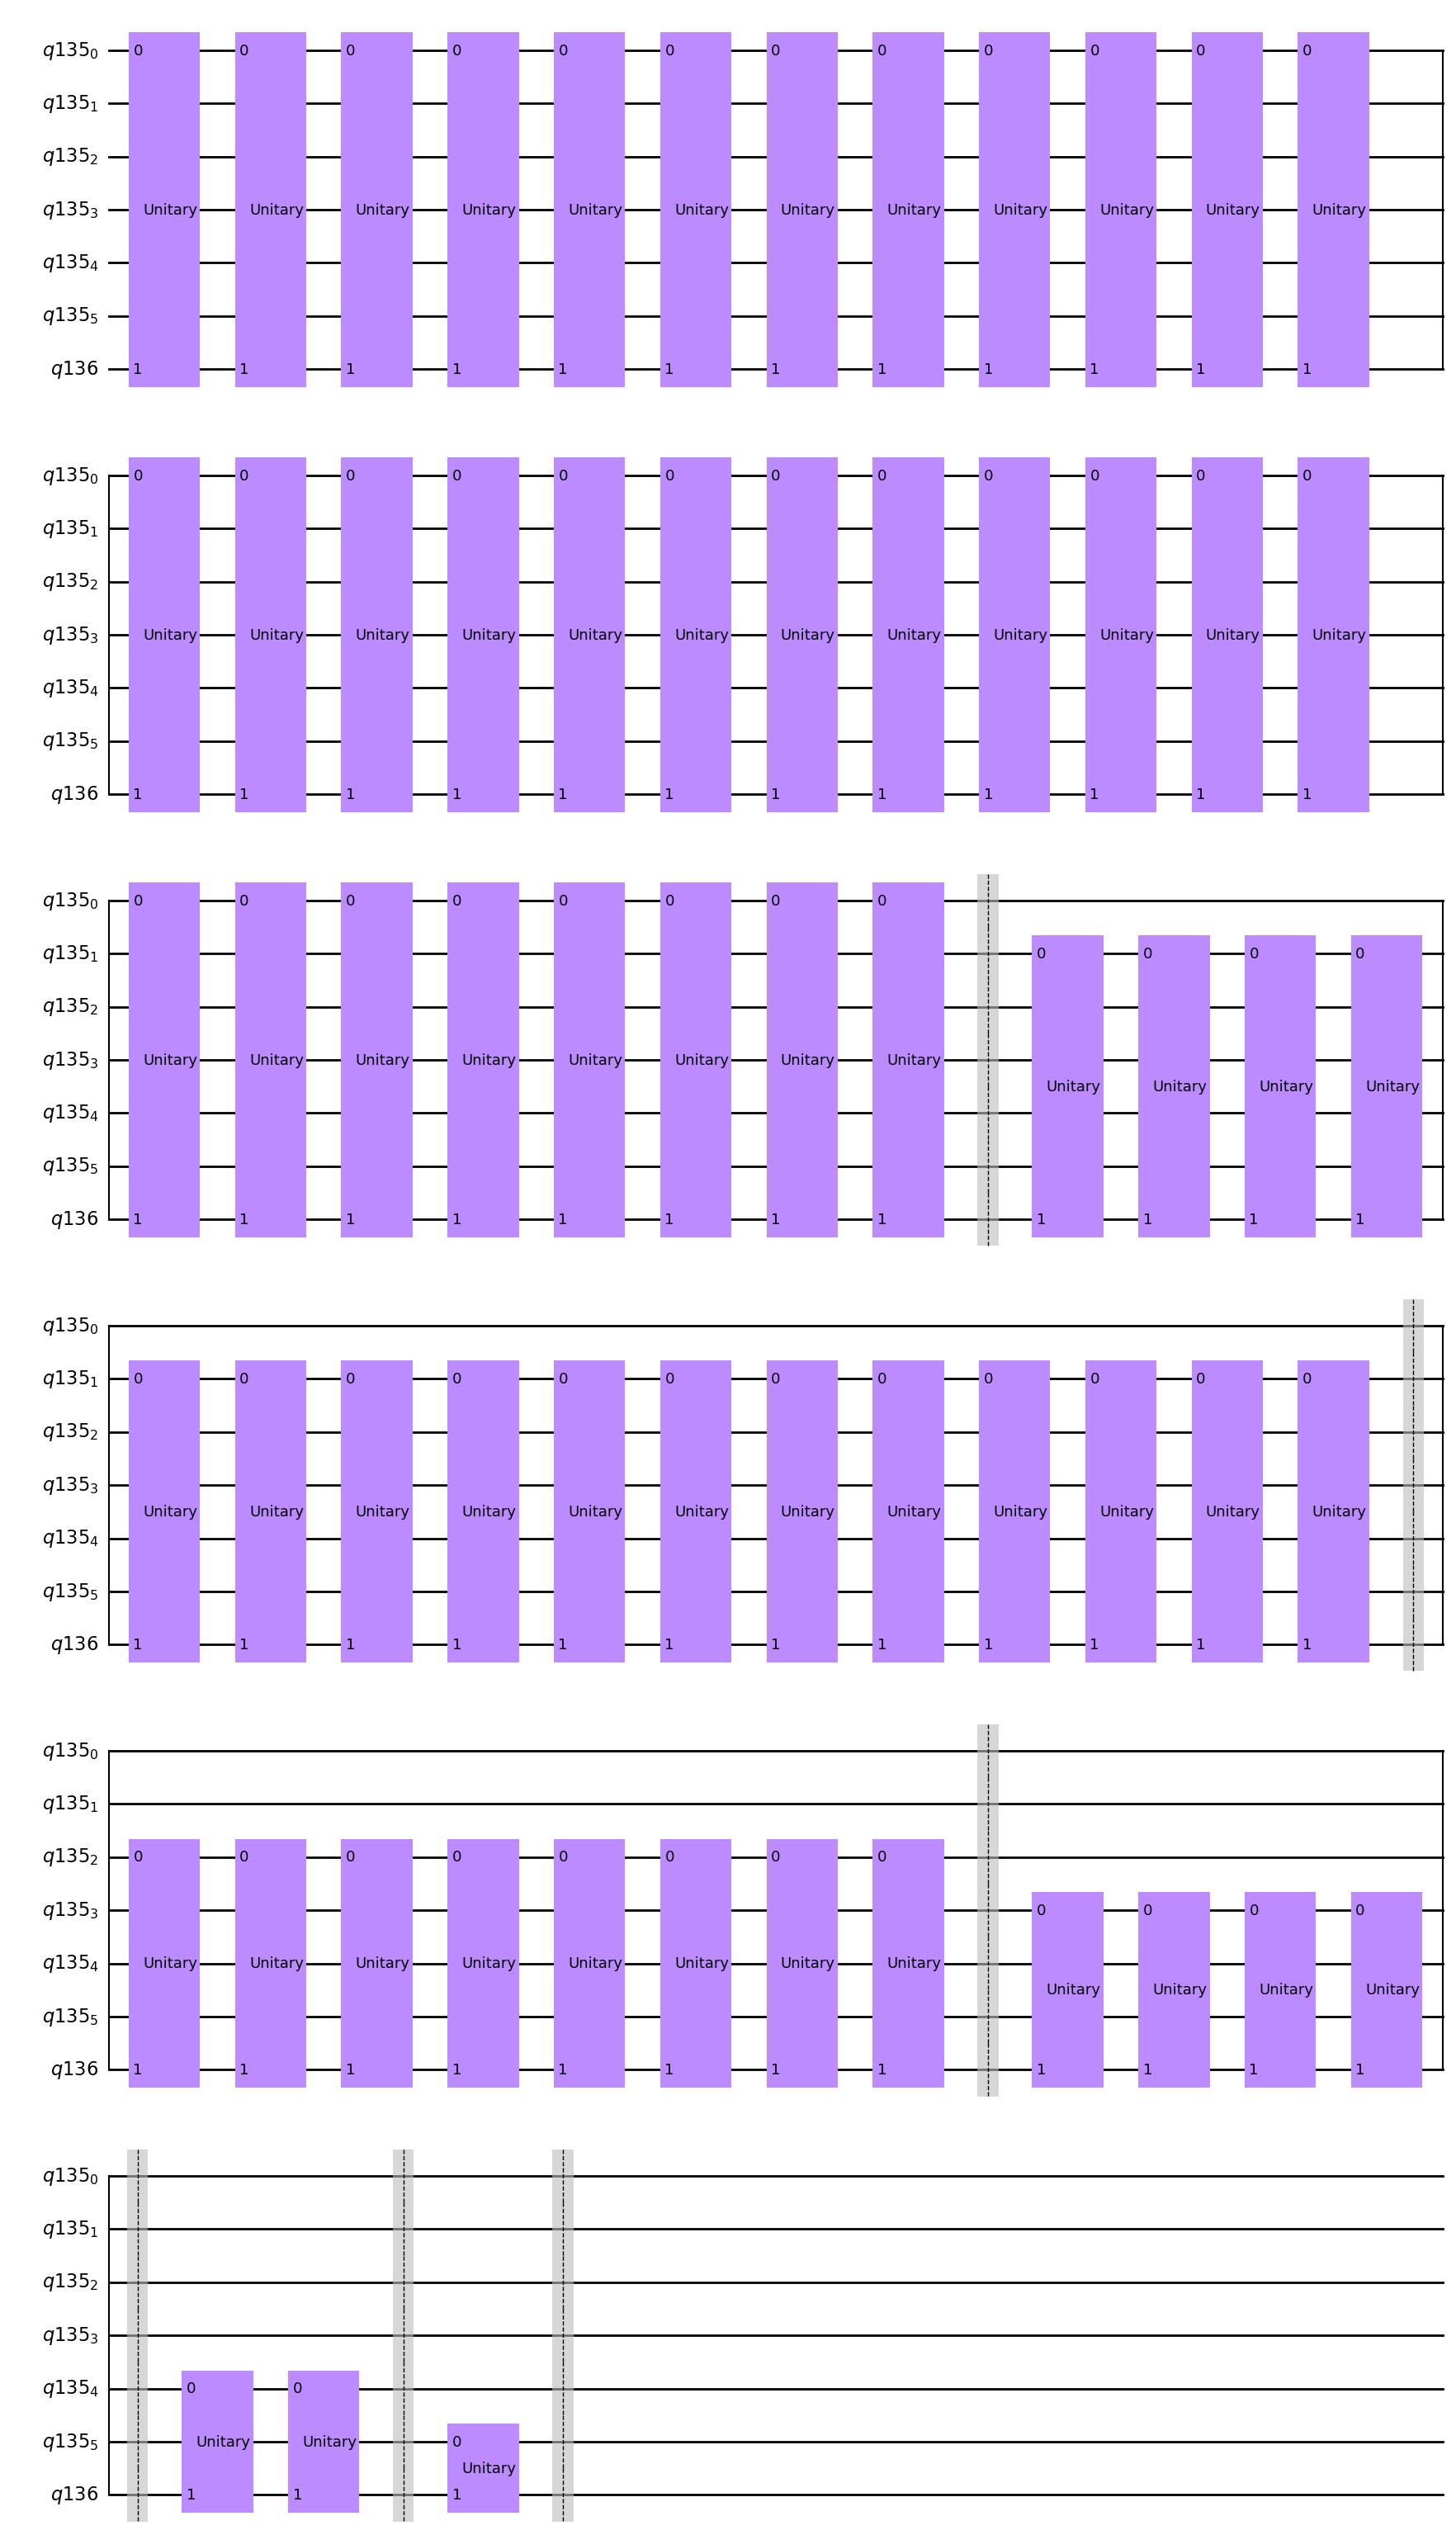

In [10]:
from qiskit import QuantumRegister, QuantumCircuit, ClassicalRegister
import qiskit.circuit.library as lib
import numpy as np
import math as m
import cmath as cm

from qiskit.circuit.library import UnitaryGate

def equal_to_int_NOT(reference_state: int, control_num: int, anc_num: int) -> QuantumCircuit:
    """
    if the state of control register corresponds to the specified integer reference, the target bit is flipped
    :param reference_state: integer, the expected value of control bits
    :param control_num: integer, the number of control bits
    :param anc_num: integer, the number of ancilla bits
    """
    control = QuantumRegister(control_num)
    anc = QuantumRegister(anc_num)
    res = QuantumRegister(1)
    qc = QuantumCircuit(control, anc, res)

    x_list = []
    for i in np.arange(control_num):
        if reference_state % 2 == 0:
            x_list.append(control[i])
        reference_state = int(reference_state / 2)

    for i in np.arange(len(x_list)):
        qc.x(x_list[i])
    qc.append(custom_mcx(control_num, anc_num), [*control, *anc, *res])
    for i in np.arange(len(x_list) - 1, -1, -1):
        qc.x(x_list[i])

    return qc

def custom_mcx(control_num: int, anc_num: int) -> QuantumCircuit:
    """
    custom mcx gate, dynamically determine the mode of mcx gate by the number of ancilla bits
    :param control_num: the number of control bits
    :param anc_num: the number of ancilla bits, use v-chain mode if ancilla is enough
    """
    control = QuantumRegister(control_num)
    anc = QuantumRegister(anc_num)
    res = QuantumRegister(1)
    qc = QuantumCircuit(control, anc, res)

    if anc_num >= (control_num - 2):
        qc.mcx(control, res[0], anc[:(control_num - 2)], mode='v-chain')
    else:
        qc.mcx(control, res[0])

    return qc

def build_U_operator(qubit_num: int, dists: np.ndarray) -> UnitaryGate:
    """
    build the unitary operator that is used in the QPE algorithm
    :param qubit_num: integer, the number of qubits that are implemented by the unitary operator
    :param dists: the distance between the n-th node and any other node
    """
    dists_complex = dists + 0j
    matrix = np.eye(2 ** qubit_num, dtype=complex)
    for i in np.arange(len(dists)):
        tmp = i + 2 ** (qubit_num - 1)
        matrix[tmp][tmp] = cm.exp(1j * 2.0 * m.pi * dists_complex[i])
    print(matrix)
    u_gate = lib.UnitaryGate(matrix)

    return u_gate


def QPE_U(control_num: int, target_num: int, dists: np.ndarray) -> QuantumCircuit:
    """
    the unitary operator in QPE, which is used to add the distance of every step
    :param control_num: integer, the number of control bits
    :param target_num: integer, the number of target bits
    :param dists: the n-th row in the distance adjacency whose size is 1 * n,
                  representing the distance between the n-th node and any other node
    """
    control = QuantumRegister(control_num)
    target = QuantumRegister(target_num)
    qc = QuantumCircuit(control, target)

    u_gate = build_U_operator(target_num + 1, dists)
    for i in np.arange(control_num):
        for _ in np.arange(2 ** (control_num - i - 1)):
            qc.append(u_gate, [control[i], *target])
        qc.barrier()

    return qc


def custom_QPE_U(control_num: int, per_qram_num: int, anc_num: int, dist_adj: np.ndarray) -> QuantumCircuit:
    """
    custom unitary operator of QPE algorithm, according the route's source add distance dynamically
    :param control_num: integer, the precision of result
    :param per_qram_num: integer, the number of choice bit
    :param anc_num: integer, must be greater than 1
    :param dist_adj: distance adjacency
    """
    control = QuantumRegister(control_num)
    source = QuantumRegister(per_qram_num)
    target = QuantumRegister(per_qram_num)
    anc = QuantumRegister(anc_num)
    qc = QuantumCircuit(control, source, target, anc)

    for i in np.arange(len(dist_adj)):
        u_gate = build_U_operator(per_qram_num + 1, dist_adj[i])
        qc.append(NOT_gate.equal_to_int_NOT(i, per_qram_num, anc_num - 1), [*source, *anc[1:], anc[0]])
        qc.ccx(control[i], anc[0], anc[1])

        for j in np.arange(control_num):
            for _ in np.arange(2 ** (control_num - j - 1)):
                qc.append(u_gate, [anc[1], *target])

        qc.ccx(control[i], anc[0], anc[1])
        qc.append(NOT_gate.equal_to_int_NOT(i, per_qram_num, anc_num - 1), [*source, *anc[1:], anc[0]])

    return qc

dists = np.zeros(2)
dists[0] = 0.25
dists[1] = 0.5625
control = QuantumRegister(6)
target = QuantumRegister(1)
cl = ClassicalRegister(6)
qc = QuantumCircuit(control, target)
qc.h(control)
# qc.append(build_U_operator(2, dists), [0, 1])
qc.append(QPE_U(6, 1, dists))
qc.append(lib.QFT(6, do_swaps=False, inverse=True), [0, 1, 2, 3, 4, 5])
qc.measure(control, cl)
